In [1]:
import os
import pandas as pd
import json
import networkx as nx 
import matplotlib.pyplot as plt 
import itertools
import math
import numpy as np

In [54]:
POSE_DIR = './raw_data/UBnormal/poses_stg'

In [3]:
# Source https://github.com/MVIG-SJTU/AlphaPose/blob/master/docs/output.md
raw_order = [
    {0,  "Nose"},
    {1,  "LEye"},
    {2,  "REye"},
    {3,  "LEar"},
    {4,  "REar"},
    {5,  "LShoulder"},
    {6,  "RShoulder"},
    {7,  "LElbow"},
    {8,  "RElbow"},
    {9,  "LWrist"},
    {10, "RWrist"},
    {11, "LHip"},
    {12, "RHip"},
    {13, "LKnee"},
    {14, "Rknee"},
    {15, "LAnkle"},
    {16, "RAnkle"},
]
order = []
for s in raw_order:
    for item in s:
        if isinstance(item, str):
            order.append(item)
            break

In [55]:
def get_files_with_suffix(directory: str, suffix: str):
    """Function that extracts the files from the given directory
    that ends with the suffix
    """
    filelist = [];
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(suffix):
                json_file = os.path.join(root,file)
                filelist.append(json_file)
    return filelist

def generate_pose_df(pose_dir):
    dfs = []
    json_files = get_files_with_suffix(pose_dir, 'alphapose_tracked_person.json')
    for file in json_files:
        video_name = '_'.join(file.split('/')[-1].split('_')[:-3])
        with open(file) as f:
            tracking_dict = json.load(f)
        pose_data = []
        for obj_id, frames in tracking_dict.items():
            for frame_id, kp_data in frames.items():
                pose_data.append(
                    {
                        'video': video_name,
                        'image_id': frame_id,
                        'keypoints': kp_data['keypoints'],
                        'score': kp_data['scores']
                    }
                )
        if not pose_data:
            print(f'No pose data found for {video_name}')
        else:
            df = pd.DataFrame(pose_data)
            df = df[['video', 'image_id', 'keypoints', 'score']]
            dfs.append(df)
    df_overview = pd.concat(dfs, ignore_index=True)
    return df_overview

def get_statistics(arr):
    arr = np.array(arr)
    quatiles = {}
    for item in (0.25,0.50, 0.75):
        quatiles[item] = np.quantile(arr, item)
    
    # Get number of outliers in boxplot
    # Source: https://www.geeksforgeeks.org/finding-the-outlier-points-from-matplotlib/
    iqr = quatiles[0.75]-quatiles[0.75]
    upper_bound = quatiles[0.75]+(1.5*iqr)
    lower_bound = quatiles[0.25]-(1.5*iqr)
    n_low_scoring_items = len(arr[arr <= lower_bound])

    statistics = {
        'quatiles': quatiles,
        'upper_bound': upper_bound,
        'lower_bound': lower_bound,
        'variance': np.var(arr),
        'n_items': len(arr),
        'n_low_scoring_items': n_low_scoring_items
    }
    return statistics

In [56]:
df_overview = generate_pose_df(POSE_DIR)

No pose data found for abnormal_scene_29_scenario_2_smoke


{'quatiles': {0.25: 2.839039385318756, 0.5: 2.9761719703674316, 0.75: 3.041617453098297}, 'upper_bound': 3.041617453098297, 'lower_bound': 2.839039385318756, 'variance': 0.16501599319239835, 'n_items': 957974, 'n_low_scoring_items': 239494}


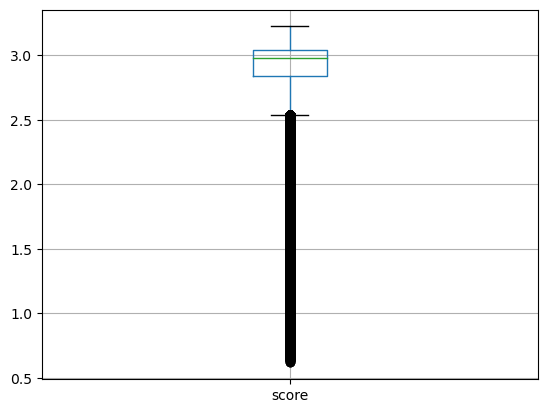

In [57]:
# Show score statistics
print(get_statistics(df_overview.score.to_list()))
df_overview.boxplot('score')
plt.show()

{'quatiles': {0.25: 0.7655330300331116, 0.5: 0.8501357436180115, 0.75: 0.8995628952980042}, 'upper_bound': 0.8995628952980042, 'lower_bound': 0.7655330300331116, 'variance': 0.03610534321877631, 'n_items': 16285558, 'n_low_scoring_items': 4071391}


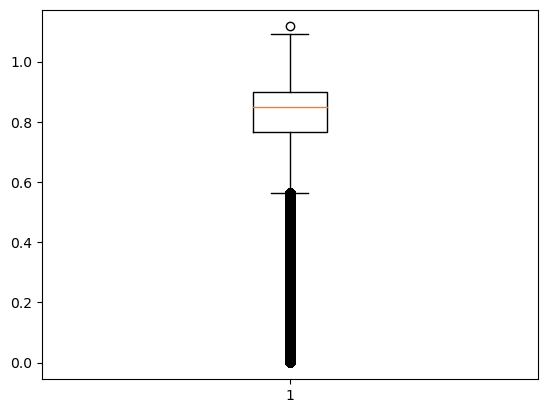

In [58]:
# Show confidence statistics
confidences = []
for kp in df_overview.keypoints.to_list():
    for i in range(17):
        c_index = 2 + (i * 3)
        confidences.append(kp[c_index])

print(get_statistics(confidences))
plt.boxplot(confidences)
plt.show()

In [59]:
def generate_tracking_df(pose_dir):
    json_files = get_files_with_suffix(POSE_DIR, 'alphapose_tracked_person.json')
    tracking_records = []
    for json_file in json_files:
        video_name = '_'.join(json_file.split('/')[-1].split('_')[:5])
        with open(json_file) as f:
            tracking_dict = json.load(f)
        for obj_id, frame_data in tracking_dict.items():
            tracking_item = {
                'video': video_name,
                'obj_id': obj_id,
                'n_frames': len(frame_data.keys())
            }
            tracking_records.append(tracking_item)
    return pd.DataFrame(tracking_records)
df_tracking = generate_tracking_df(POSE_DIR)

Total number of tracked objects: 4097
Number of tracked objects with less than 12 frames: 986


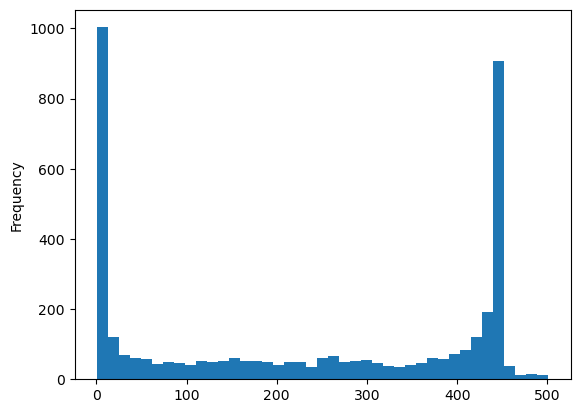

In [60]:
print('Total number of tracked objects:', df_tracking.shape[0])
print('Number of tracked objects with less than 12 frames:', df_tracking[df_tracking.n_frames < 12].shape[0])
df_tracking['n_frames'].plot.hist(bins=500//12)
plt.show()

In [ ]:
with open('./UBNormalAlphaPoseOutput/abnormal_scene_8_scenario_5_alphapose_tracked_person.json') as f:
    tracking = json.load(f)

In [ ]:
tracking

In [ ]:
key_points = tracking['1']['0000']['keypoints']
converted_keypoints = []
for i in range(0, len(key_points), 3):
    x = key_points[i]
    y = key_points[i+1]
    c = key_points[i+2]
    co = (x,y)
    converted_keypoints.append((co, c))

In [ ]:
# Source: https://www.geeksforgeeks.org/visualize-graphs-in-python/
# https://stackoverflow.com/questions/32488772/drawing-nodes-with-coordinates-in-correct-position-using-networkx-matplotlib
class GraphVisualization: 
   
    def __init__(self): 
          
        # visual is a list which stores all  
        # the set of edges that constitutes a 
        # graph 
        self.G = nx.Graph()
          
    # addEdge function inputs the vertices of an 
    # edge and appends it to the visual list 
    def addNode(self, name, pos):
        self.G.add_node(name, pos=(pos[0], -pos[1])) # inverse Y for better representation
    
    def addEdge(self, n1, n2, weight): 
        #self.G.add_edges_from([(n1, n2)])
        self.G.add_edge(n1, n2, weight=weight)
 
    # In visualize function G is an object of 
    # class Graph given by networkx G.add_edges_from(visual) 
    # creates a graph with a given list 
    # nx.draw_networkx(G) - plots the graph 
    # plt.show() - displays the graph 
    def visualize(self): 
        nx.draw_networkx(self.G, nx.get_node_attributes(self.G, 'pos')) 
        # edge_labels = nx.get_edge_attributes(G, "weight")
        # nx.draw_networkx_edge_labels(self.G, nx.get_node_attributes(self.G, 'pos'), edge_labels)        
        plt.show() 

In [ ]:
connections = [
    (5,6),
    (5,7),
    (6,8),
    (7,9),
    (8,10),
    (5,11),
    (6,12),
    (11, 12),
    (11,13),
    (12, 14),
    (13, 15),
    (14, 16)
]

In [ ]:
G = GraphVisualization() 
for i, kp in enumerate(converted_keypoints):
    kp_name = order[i]
    G.addNode(kp_name, kp[0])
    # G.addEdge(kp[0], converted_keypoints[i+1][0]) 
for source, target in connections:
    n1 = order[source]
    n2 = order[target]
    co1 = converted_keypoints[source][0]
    co2 = converted_keypoints[target][0]
    weight = math.dist(co1, co2)
    G.addEdge(n1, n2, weight)
G.visualize() 

In [ ]:
G = GraphVisualization() 
for i, kp in enumerate(converted_keypoints):
    kp_name = order[i]
    G.addNode(kp_name, kp[0])
    # G.addEdge(kp[0], converted_keypoints[i+1][0]) 
for source, target in list(itertools.permutations([i for i in range(0, 17)], 2)):
    n1 = order[source]
    n2 = order[target]
    co1 = converted_keypoints[source][0]
    co2 = converted_keypoints[target][0]
    weight = math.dist(co1, co2)
    G.addEdge(n1, n2, weight)
G.visualize() 